<a href="https://colab.research.google.com/github/chantmk/NLP_2021/blob/main/HW5/thai_skip_gram_homework_for_student_v2020s2_finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!nvidia-smi

Sat Feb 20 04:40:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |    417MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [16]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

random.seed(42)

# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [17]:
!wget https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
!wget https://www.dropbox.com/s/n87fiy25f2yc3gt/wiki.zip
!unzip wiki.zip
!unzip BEST-TrainingSet.zip

--2021-02-20 04:40:07--  https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eexden7246sgfzf/BEST-TrainingSet.zip [following]
--2021-02-20 04:40:08--  https://www.dropbox.com/s/raw/eexden7246sgfzf/BEST-TrainingSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11877ba0c0f0ce25a81cf93848.dl.dropboxusercontent.com/cd/0/inline/BJSC-DnV7awny3TPHL3dtS6oN6QajW-b4pL6PgZ6rvrL8EtqOKhKPbtvZsdwi-aKhk2w2MIe0hCrUN9GRJnNzC3M5ym39OgtvYWut1bYkft4436UmpMiJjU0ZbpI6wQkq6A/file# [following]
--2021-02-20 04:40:08--  https://uc11877ba0c0f0ce25a81cf93848.dl.dropboxusercontent.com/cd/0/inline/BJSC-DnV7awny3TPHL3dtS6oN6QajW-b4pL6PgZ6rvrL8EtqOKhKPbtvZsdwi-aKhk2w2MIe0hCrUN9GRJnN

In [18]:
#Step 1: read the wikipedia text file
with open("wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [19]:
tokens = input_text
print(tokens[:10])
print("total word count:", len(tokens))

['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
total word count: 36349066


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='blue'>Homework Question 1:</font>
<font color='white'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='white'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

In [20]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text, min_thres_unk = 0, max_word_count = None):
    # TODO#1 : edit or replace this function
    words = [word for word in input_text ]
    word_count = list()

    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    word_count.append(("UNK",min_thres_unk+1))
    #print out 10 most frequent words
    print(word_count[:10])

    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        # Added here
        if word[1] > min_thres_unk :
            dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        # Add here
        if word in dictionary :
            data.append(dictionary[word])
        else :
            data.append(dictionary["UNK"])

    return data,dictionary, reverse_dictionary

# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary = create_index(tokens, 1)

[('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830)]


In [21]:
print("size dataset: {}".format(len(dataset)))
print("size dictionary: {}".format(len(dictionary)))
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

size dataset: 36349066
size dictionary: 295164
output sample (dataset): [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, ')': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: ')'}


In [22]:
dataset.count(dictionary["UNK"])

406196

# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='blue'>Homework Question 2:</font>
<font color='white'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



<font color='red'>Q2: PUT YOUR ANSER HERE!!!</font>

The probability function is different, for in-class it is 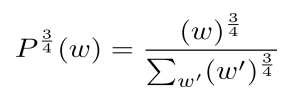 

while keras it is `P(class) = (log(class + 2) - log(class + 1)) / log(range_max + 1)`

In [23]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])



[[208, 83708], [208, 2453], [2453, 573], [208, 235515], [24, 681], [2453, 208], [3124, 145853], [2453, 115575], [24, 3408], [208, 229], [3124, 681], [3124, 7149], [3124, 285707], [2453, 219950]] [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
หลัก Merlin
หลัก วิกิพีเดีย
วิกิพีเดีย ดำเนินการ
หลัก LaVoie
ไม่ องค์กร
วิกิพีเดีย หลัก
มีเดีย -House
วิกิพีเดีย (หงส์ทอง


# Step 4: create the skip-gram model
## <font color='blue'>Homework Question 3:</font>
 <font color='white'>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

<font color='red'>Q3: PUT YOUR ANSER HERE!!!</font>

Since full softmax computation is expensive we use negative sampling with sigmoid which result in binary classification

In [24]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V+1, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V+1, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 32)        9445280     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 32)        9445280     input_4[0][0]                    
____________________________________________________________________________________________

In [25]:
precount = 5
SkipGram.load_weights('/content/drive/MyDrive/Lecture/Senior/2/NLP/my_skipgram32_weights-hw-{}.h5'.format(precount-1))

In [ ]:
import time

In [ ]:
# you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# currently the dataset is 1/20 of the full text file.
start = time.time()
for c in range(5-precount):
    prev_i=0
    #it is likely that your GPU won't be able to handle large input
    #just do it 100000 words at a time
    for i in range(len(dataset)//100000):
        #generate skipgrams
        data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
        prev_i = i 
        print(loss,i*100000)
    end = time.time()
    try :
        print("Fin {} epoch, time used {}".format(c+precount+1, end-start))
        SkipGram.save_weights('/content/drive/MyDrive/Lecture/Senior/2/NLP/my_skipgram32_weights-hw-{}.h5'.format(c+precount))
    except :
        print("Shit")

0.08427571505308151 0
0.08742646127939224 100000
0.08784645795822144 200000
0.08215413987636566 300000
0.08335798978805542 400000
0.08644331246614456 500000
0.08251987397670746 600000
0.08288801461458206 700000
0.08565189689397812 800000
0.09073720127344131 900000
0.09155973047018051 1000000
0.08546909689903259 1100000
0.0881616398692131 1200000
0.08595794439315796 1300000
0.08744120597839355 1400000
0.09393469244241714 1500000
0.09318114072084427 1600000
0.09148932993412018 1700000
0.09052248299121857 1800000
0.09066732972860336 1900000
0.09269395470619202 2000000
0.08937197923660278 2100000
0.08669354766607285 2200000
0.08783873915672302 2300000
0.08765890449285507 2400000
0.08978867530822754 2500000
0.08857735246419907 2600000
0.09507140517234802 2700000
0.10279669612646103 2800000
0.10012421756982803 2900000
0.09411836415529251 3000000
0.09510136395692825 3100000
0.10118669271469116 3200000
0.10289372503757477 3300000
0.1018512025475502 3400000
0.09951899200677872 3500000
0.0973807

In [26]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[-4.4611838e-02  3.7928227e-02  1.3160955e-02 ...  2.9036392e-02
  -2.6165187e-02 -3.4383155e-02]
 [ 1.0817220e+00 -3.7302560e-01  2.0129755e-01 ... -6.4706260e-01
   1.6708435e+00  2.1098122e-01]
 [ 1.1989682e+00  8.8132089e-01 -6.1816007e-01 ...  9.6960938e-01
   1.0882146e+00 -2.6347410e-02]
 ...
 [ 4.2698529e-02 -4.0585399e-03 -4.5627501e-02 ... -3.1900242e-02
   1.5793290e-02  5.4097176e-04]
 [ 4.1859601e-02  4.0867340e-02 -5.8749318e-03 ...  3.7457202e-02
   3.9320674e-02 -1.1523254e-03]
 [-1.4914992e-01 -1.1878514e-01 -2.6940602e-01 ... -4.8992574e-01
   8.8861096e-01  5.2244741e-01]]
(295165, 32)


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='blue'>Homework Question 4: </font>
<font color='white'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings </font>


In [ ]:
# TODO#4:Come up with 10 semantic analogy examples and report results produced by your word embeddings 
#and tell us what you observe 

From the nearest function, it shows that the model grouping the word accurately but when it comes to analogy the result is not good enough.
For instance, when it guess "พระราชา" : "ชาย" :: "พระราชินี" the expected result is "หญิง" but the model return "ชาย" as the nearest follow by prefer result "หญิง", this may caused by poor tokenizing, small number of epoch or context from the given data.

In [185]:
def word2vec(word):
    try :
        return final_embeddings[dictionary[word]]
    except:
        print("UNK", word)
        return final_embeddings[dictionary["UNK"]]

def nearest(word):
    vec = word2vec(word)
    cosine_sim = np.dot(vec, final_embeddings.T) / (np.linalg.norm(vec)*np.linalg.norm(final_embeddings, axis=1))
    indexes = np.argpartition(cosine_sim, -10)[-10:]
    return np.array([reverse_dictionary[e] for e in indexes])

def analogy(a, b, c):
    a_vec = word2vec(a)
    b_vec = word2vec(b)
    c_vec = word2vec(c)
    d_vec = b_vec - a_vec + c_vec
    cosine_sim = np.dot(d_vec, final_embeddings.T) / (np.linalg.norm(d_vec)*np.linalg.norm(final_embeddings, axis=1))
    indexes = np.argsort(cosine_sim)[-10:][::-1]
    print("{} : {} :: {} : {}".format(a, b, c, [reverse_dictionary[d] for d in indexes]))

In [198]:
nearest("แดง")

array(['เทา', 'ม่วง', 'สี', 'เขียว', 'น้ำเงิน', 'เหลือง', 'ดำ', 'ชมพู',
       'แดง', 'ขาว'], dtype='<U7')

In [197]:
nearest("มกราคม")

array(['พฤษภาคม', 'กันยายน', 'มิถุนายน', 'สิงหาคม', 'มีนาคม', 'เมษายน',
       'กุมภาพันธ์', 'มกราคม', 'ตุลาคม', 'พฤศจิกายน'], dtype='<U10')

In [207]:
nearest("ญี่ปุ่น")

array(['อิตาลี', 'ไต้หวัน', 'จีน', 'ของจีน', 'สากล', 'อังกฤษ', 'เยอรมัน',
       'ดัตช์', 'เกาหลี', 'ญี่ปุ่น'], dtype='<U7')

In [208]:
analogy("พระราชา", "ชาย" , "พระราชินี")
for a in ["ลาว", "สิงคโปร์", "พม่า", "จีน", "เขมร"] :
    analogy("ญี่ปุ่น", "โตเกียว" , a)
    analogy("ไทย", "กรุงเทพ" , a)


พระราชา : ชาย :: พระราชินี : ['ชาย', 'หญิง', 'กิจวิจารณ์', 'หลุย', 'เวลส์', 'บันดาร์เซอรี', 'เอี่ยมศรี', 'วอลเลย์บอล', 'อัครินทร์', 'คฤพล']
ญี่ปุ่น : โตเกียว :: ลาว : ['สุราษฎร์ธานี', 'นครศรีธรรมราช', 'พังงา', 'ภูเก็ต', 'หนองบัว', 'นคร', 'ซึ่งตั้ง', 'ตราด', 'ย่าน', 'ยะลา']
ไทย : กรุงเทพ :: ลาว : ['ซึ่งตั้ง', 'สนามบิน', 'ลาดพร้าว', 'ปทุมวัน', 'นครศรีธรรมราช', 'ตั้ง', 'ถนนพระราม', 'นนทบุรี', 'ทวีวัฒนา', 'ตราด']
ญี่ปุ่น : โตเกียว :: สิงคโปร์ : ['โตเกียว', 'ชานเมือง', 'สุราษฎร์ธานี', 'ประเทศออสเตรเลีย', 'พลาซา', 'เซนท์', 'ลาดพร้าว', 'บางนา', 'สนามบิน', 'ตราด']
ไทย : กรุงเทพ :: สิงคโปร์ : ['สนามบิน', 'รัฐอิลลินอยส์', 'ลอนดอน', 'รัฐนิวยอร์ก', 'ลาดพร้าว', 'ซึ่งตั้ง', 'ไอวีบี', 'พลาซา', 'ประเทศสหรัฐอเมริกา', 'โตเกียว']
ญี่ปุ่น : โตเกียว :: พม่า : ['นคร', 'อาณาเขต', 'บรรจบ', 'ยะลา', 'ประเทศเวียดนาม', 'ตราด', 'ปัตตานี', 'นครศรีธรรมราช', 'เลียบ', 'เสียมราฐ']
ไทย : กรุงเทพ :: พม่า : ['ย่างกุ้ง', 'มุ่งหน้า', 'ห่าง', 'สนามบิน', 'ปริมณฑล', 'ซึ่งตั้ง', 'เลี้ยว', 'ไอบีเรีย', 'ถิ่นฐาน', 'อาณาเขต']
ญี่ปุ

# Step 6: Extrinsic Evaluation

## <font color='blue'>Homework Question5:</font>
<font color='white'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [27]:
all_news_filepath = glob.glob('BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('BEST-TrainingSet/encyclopedia/*.txt')

In [28]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [33]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2000, 32)          9445280   
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 9,451,748
Trainable params: 9,451,748
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 17s 1s/step - loss: 1.3633 - accuracy: 0.3273 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 1.2591 - accu

In [30]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 1s 99ms/step - loss: 2.6134 - accuracy: 0.5000
test loss, test acc: [2.613426446914673, 0.5]


In [31]:
from keras.initializers import Constant 

In [34]:
cls_model_embedding = Sequential()
cls_model_embedding.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True, embeddings_initializer=Constant(final_embeddings)))
cls_model_embedding.add(GRU(32))
cls_model_embedding.add(Dropout(0.5))
cls_model_embedding.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model_embedding.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model_embedding.summary()
print('Train...')
cls_model_embedding.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2000, 32)          9445280   
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 9,451,748
Trainable params: 9,451,748
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 26s 2s/step - loss: 1.4531 - accuracy: 0.3261 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 16s 1s/step - loss: 1.1605 - accu

In [109]:
results = cls_model_embedding.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 1s 105ms/step - loss: 0.8444 - accuracy: 0.7549
test loss, test acc: [0.8444308638572693, 0.7549019455909729]
